# Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.contingency import association
from scipy.stats import f_oneway,ttest_ind,ttest_1samp

# Extração da base

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/JackyP/testing/master/datasets/nycflights.csv", index_col=0)


In [3]:
df.shape

(336776, 16)

# Qualidade dos Dados

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336776 entries, 1 to 336776
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       336776 non-null  int64  
 1   month      336776 non-null  int64  
 2   day        336776 non-null  int64  
 3   dep_time   328521 non-null  float64
 4   dep_delay  328521 non-null  float64
 5   arr_time   328063 non-null  float64
 6   arr_delay  327346 non-null  float64
 7   carrier    336776 non-null  object 
 8   tailnum    334264 non-null  object 
 9   flight     336776 non-null  int64  
 10  origin     336776 non-null  object 
 11  dest       336776 non-null  object 
 12  air_time   327346 non-null  float64
 13  distance   336776 non-null  int64  
 14  hour       328521 non-null  float64
 15  minute     328521 non-null  float64
dtypes: float64(7), int64(5), object(4)
memory usage: 43.7+ MB


In [5]:
df.isna().sum()

year            0
month           0
day             0
dep_time     8255
dep_delay    8255
arr_time     8713
arr_delay    9430
carrier         0
tailnum      2512
flight          0
origin          0
dest            0
air_time     9430
distance        0
hour         8255
minute       8255
dtype: int64

Uma vez que os atrasos são nossa resposta, vamos retirar os casos em que eles são na

In [6]:
df.dropna(subset=['arr_delay','dep_delay'],inplace=True)

In [7]:
df.isna().sum().sum()

0

In [8]:
df.duplicated().sum()

0

Está OK

# Analise dos dados

Primeiros vamos criar um date-time para futuras análises e tratar a variável flight

In [9]:
df["data"] = pd.to_datetime(df[['year', 'month', 'day']]) 
df.flight = df.flight.astype('str')

## 1.Variavel Resposta

Queremos medir atraso, como vamos criar essa medida?
- Temos atraso na partida e na chegada. Podemos utilizar a soma dos dois como uma métrica de atraso total

In [10]:
df['atraso_total'] = df.dep_delay + df.arr_delay

In [11]:
df.atraso_total.describe()

count    327346.000000
mean         19.450532
std          82.880678
min        -100.000000
25%         -21.000000
50%          -6.000000
75%          22.000000
max        2573.000000
Name: atraso_total, dtype: float64

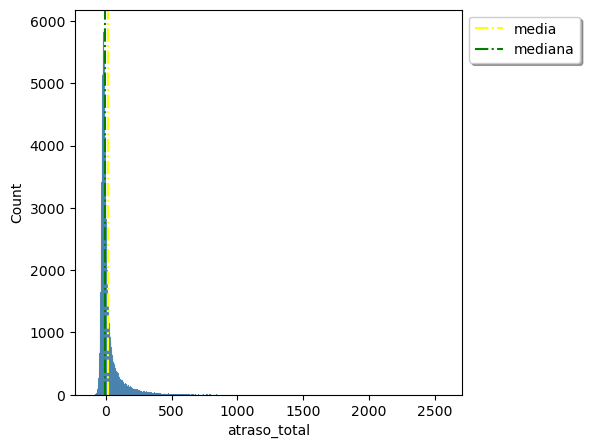

In [12]:
plt.figure(figsize=(5, 5))
sns.histplot(data=df,
             x='atraso_total',
             discrete=True)
plt.axvline(df.atraso_total.mean(),color='yellow',ls='-.',label='media')
plt.axvline(df.atraso_total.median(),color='green',ls='-.',label='mediana')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left',fancybox=True,shadow=True)
plt.show()

Uma vez que não temos uma distribuição normal, vamos utilizar o Chebyshev

In [13]:
def analisa_outliers(base,parametro,k):
    intervalo = (1-(1/k**2))*100
    valores_min = base[parametro].mean() - k*base[parametro].std() 
    valores_max = base[parametro].mean() + k*base[parametro].std() 
    print(f'Para um intervalo de confiança de {(round(intervalo,2))}% teremos entre \n {round(valores_min,2)} e {round(valores_max,2)}')

In [14]:
analisa_outliers(base=df,
                 parametro='atraso_total',
                 k=3)

Para um intervalo de confiança de 88.89% teremos entre 
 -229.19 e 268.09


## 2. Analises Iniciais

### Por data

Vamos entender os outliers presentes na base, pois atrasos de mais de 268 minutos (4 horas) são críticos

<Axes: xlabel='month', ylabel='atraso_total'>

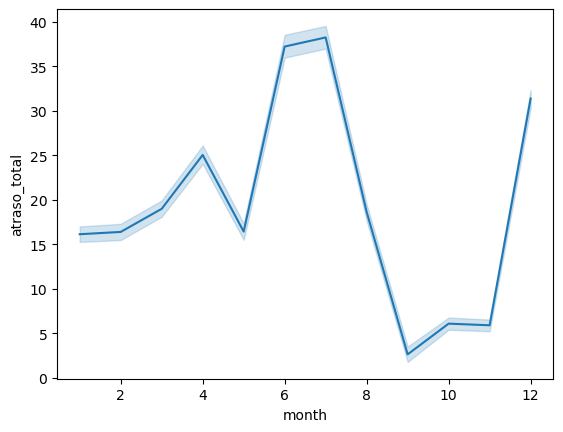

In [15]:
sns.lineplot(data=df,
             x='month',
             y='atraso_total')

Podemos perceber que os meses de férias são críticos (6,7,8 e 12)
Enquanto que a baixa temporada (meses 9,10,11) estão bem abaixo

In [16]:
df.loc[df.atraso_total > 268,'OUTLIER'] = 'SIM'
df.loc[df.OUTLIER.isna(),'OUTLIER'] = 'NAO'

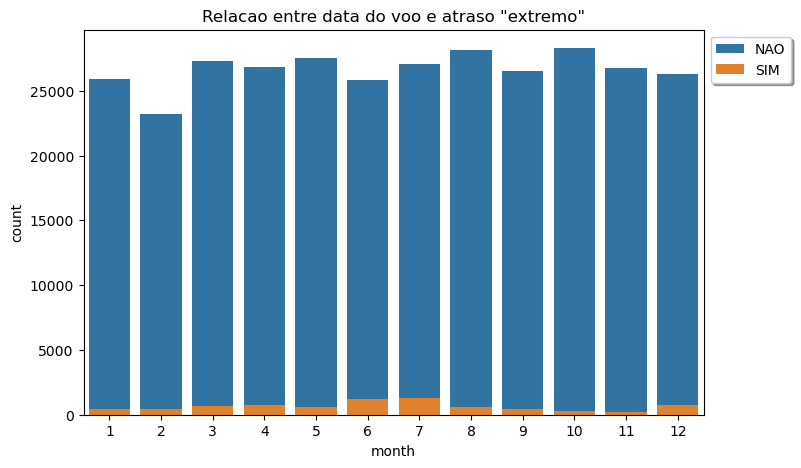

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(data=df,
              x='month',
              hue='OUTLIER',
              dodge=False)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left',fancybox=True,shadow=True)
plt.title('Relacao entre data do voo e atraso "extremo"')
plt.show()

Aqui podemos perceber que o mesmo comportamento geral é replicado para os casos extremos

### Por CIA Aerea

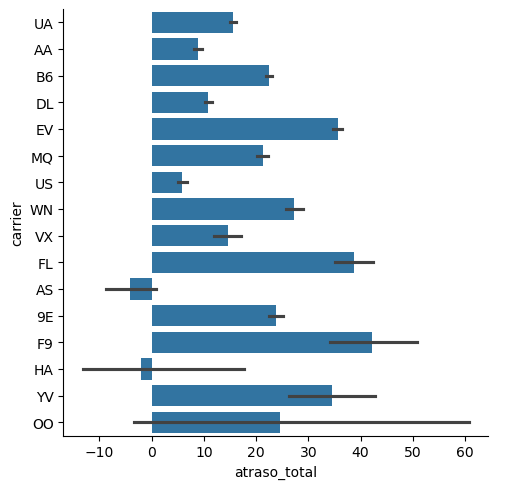

In [18]:
sns.catplot(data=df,
            x='atraso_total',
            y='carrier',
            kind='bar');

In [19]:
df.OUTLIER.value_counts(normalize=True)

OUTLIER
NAO    0.97649
SIM    0.02351
Name: proportion, dtype: float64

In [20]:
base_apoio = df.groupby('carrier').OUTLIER.value_counts(normalize=True).reset_index()
base_apoio[(base_apoio.OUTLIER == 'SIM')&
           (base_apoio.proportion > 0.02)][['carrier','proportion']].sort_values('proportion',
                                                                                 ascending=False)

,carrier,proportion
21,OO,0.068966
13,F9,0.045521
31,YV,0.044118
15,FL,0.039055
11,EV,0.037372
1,9E,0.035041
29,WN,0.031302
27,VX,0.028342
7,B6,0.023442


In [21]:
df[df.carrier.isin(['OO','F9','EV','YV','FL'])].groupby('carrier').atraso_total.agg(['mean','median','std'])

,mean,median,std
carrier,,,
EV,35.635360,-1.0,95.168201
F9,42.121880,8.0,117.970179
FL,38.721890,6.0,105.406728
OO,24.517241,-13.0,90.777051
YV,34.455882,-4.0,100.725992


Podemos observar aqui que temos algumas companhias que estão propensas a ter maior incidência desses casos, mais precisamente:
- OO &rarr; Maior range de todos (tanto atrasa muito quanto tem ótimos indices de atraso)
- F9 &rarr; Mais crítica
- YV &rarr; Ainda tem muitos casos sem atraso
- FL &rarr; Segunda mais crítica
- EV &rarr; Idem YV

O contrário também ocorre para as seguintes cias:

- AS
- HA

### Origem do Voo

In [22]:
df.groupby('origin').atraso_total.agg(['mean','median','std'])

,mean,median,std
origin,,,
EWR,24.116165,-4.0,85.135466
JFK,17.575088,-7.0,81.050496
LGA,16.070071,-8.0,81.937556


In [23]:
amostra1 = df[df.origin == 'EWR'].atraso_total
amostra2 = df[df.origin == 'JFK'].atraso_total
amostra3 = df[df.origin == 'LGA'].atraso_total

In [24]:
anova = f_oneway(amostra1,amostra2,amostra3)

In [25]:
print(f'Temos que o resultado é {anova.statistic} e o p-value é {anova.pvalue}')



Temos que o resultado é 298.17862843554667 e o p-value é 4.173340745753458e-130


Sendo assim, a origem influencia no resultado


Sendo assim, podemos tirar desta análise inicial que iremos querer tratar nossa variavel resposta como atraso total (soma dos atrasos) e que devemos criar classificações para os meses, ao invés dos números em si

In [26]:
df_2 = df

In [27]:
df_2.loc[df.month.isin([6,7,8,12]),'MES_FERIAS'] = 'FERIAS'
df_2.loc[df.month.isin([9,10,11]),'MES_FERIAS'] = 'BAIXA_TEMPORADA'
df_2.loc[df.month.isin([1,2,3,4,5]),'MES_FERIAS'] = 'PADRAO'
df_2.loc[df.MES_FERIAS.isna(),'MES_FERIAS'] = 'ERREI'

Agora vamos analisar o comportamento do atraso sem os casos em que o voo foi adiantado

In [28]:
df_2.atraso_total[df_2.atraso_total >0].describe(percentiles=[.25,.5,.75,.9,.99])

count    135059.000000
mean         74.745800
std         105.959706
min           1.000000
25%          12.000000
50%          34.000000
75%          94.000000
90%         198.000000
99%         495.000000
max        2573.000000
Name: atraso_total, dtype: float64

Por fim, uma vez que o atraso, é muito sensivel devemos segmentar ele em:
- Não Atrasou (atraso_total =< 0) --> Caso ideal
- Atraso Pontual (0 < atraso =<96) --> Caso de atenção
- Atraso Crítico (atraso >=74) --> Caso crítico

In [29]:
df_2.loc[df_2.atraso_total <= 0,'ATRASO'] = 'NAO_ATRASO'
df_2.loc[(df_2.atraso_total > 0)&(df_2.atraso_total <= 94),'ATRASO'] = 'ATENCAO'   
df_2.loc[df_2.atraso_total >94,'ATRASO'] = 'CRITICO'
df_2.loc[df_2.ATRASO.isna(),'ATRASO'] = 'erro'   

In [30]:
df_2.ATRASO.value_counts(normalize=True)

ATRASO
NAO_ATRASO    0.587412
ATENCAO       0.309770
CRITICO       0.102818
Name: proportion, dtype: float64

Sendo assim, os valores de referencia são:
- NÃO ATRASO: 58,74%
- ATENCAO: 30,98%
- CRITICO: 10,28% 

Construção da métrica OK

## 2.Variaveis Numericas

### Tratamento Base

Primerio, vamos retirar as colunas de
- Year &rarr; Entropia de 0 pois temos apenas dados de 2013
- hour, minute, dep_time, arr_time &rarr; Vamos retirar pois não usaremos hora e minuto em nossa base
- data &rarr; As colunas de mes e dia já nos oferece essa métrica

In [31]:

df_2_num = df_2.drop(labels=['year','hour','minute','data','arr_time','dep_time'],
                     axis='columns')

In [32]:
df_2_num = df_2_num.select_dtypes(exclude='object')

Uma vez que arr_delay, dep_delay e atraso_total são parte da resposta, vamos retirá-los tb

In [33]:
df_2_num.drop(labels=['arr_delay','dep_delay','atraso_total'],axis='columns',inplace=True)

In [34]:
df_2_num = pd.concat([df_2_num,df_2.ATRASO],axis='columns')

### Medindo a correlação das variáveis:

- Linear?

<Axes: >

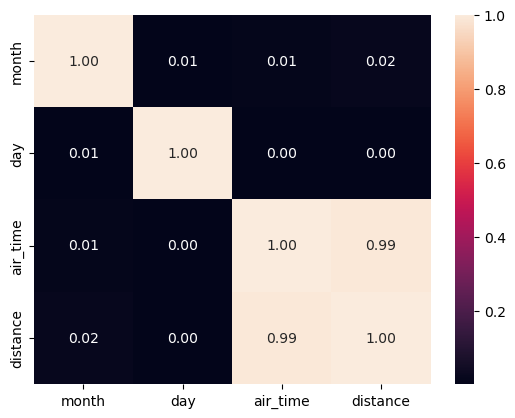

In [35]:
sns.heatmap(data=df_2_num.select_dtypes(exclude='object').corr(),
            annot=True,
            fmt='.2f')

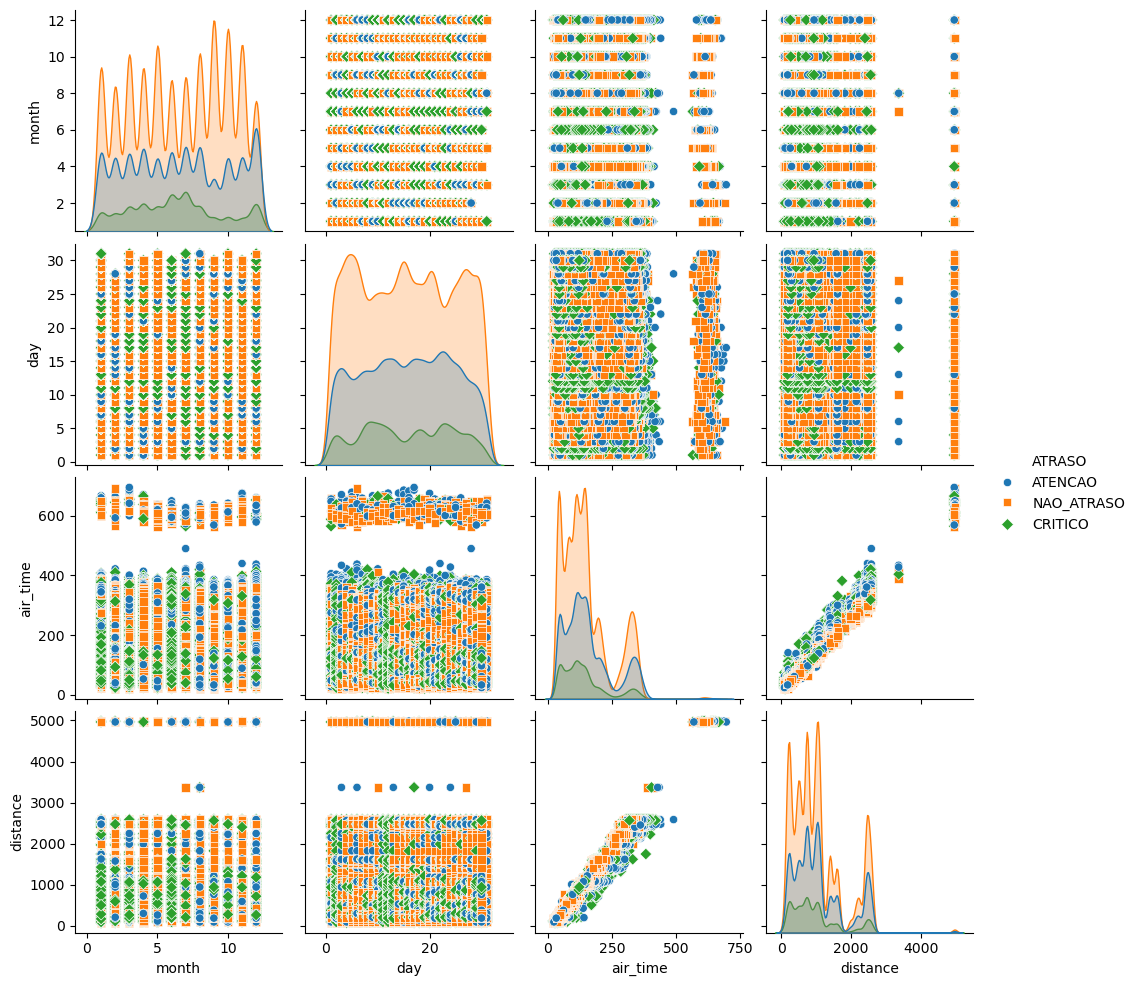

In [36]:
sns.pairplot(data=df_2_num,
             hue='ATRASO',
             markers=["o", "s", "D"]);

Obsviamente, quanto mais distância percorrida, mais tempo o mesmo fica no ar.\
Podemos observar também que as proporções dos atrasos se mantêm iguais na maioria das variáveis.\
Ao observar o dia, vamos analisar com mais detalhes

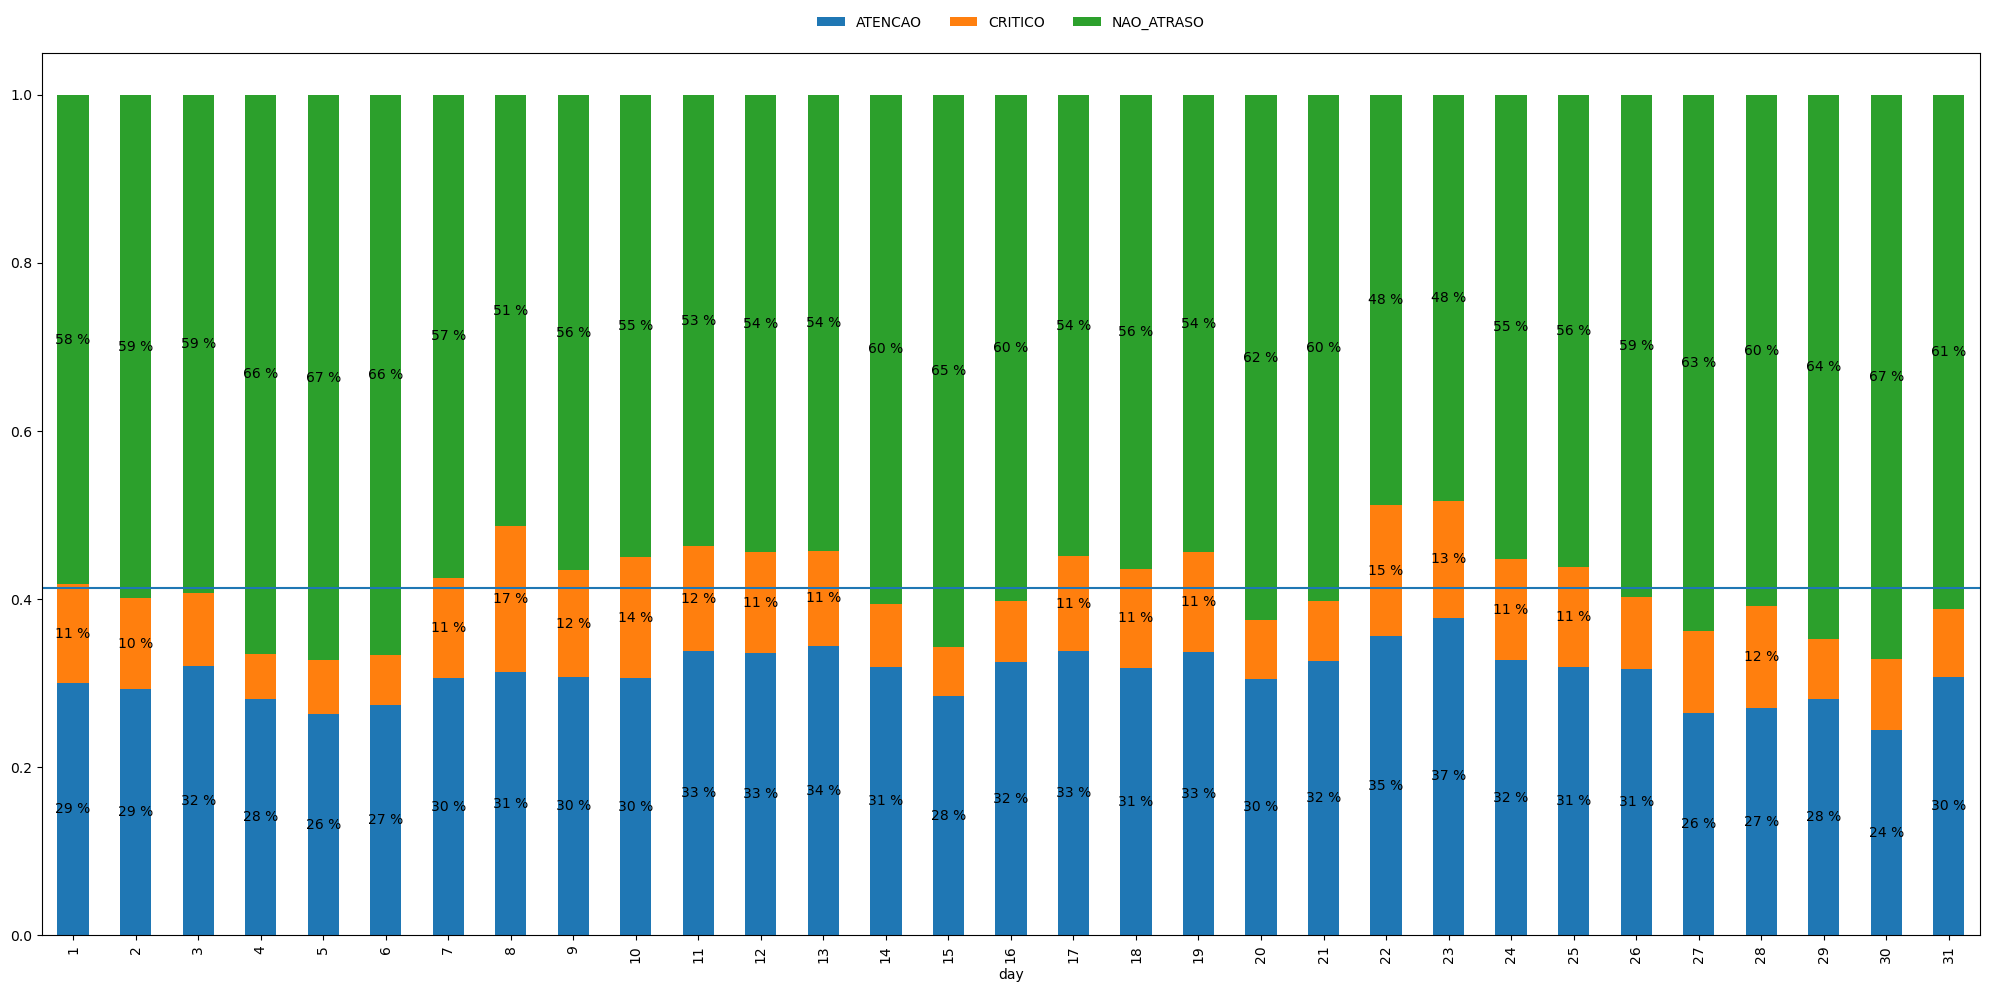

In [37]:
df_dia_pec = df_2_num.groupby('day')['ATRASO'].value_counts(normalize=True).unstack('ATRASO')
df_dia_pec.plot.bar(stacked=True,figsize=(20,10))
plt.legend(
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
for ix, row in df_dia_pec.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in row:
        if element == element and element > 0.1:
            plt.text(
                ix,
                cumulative + element / 2,
                f"{int(element * 100)} %",
                va="center",
                ha="center",
            )
        cumulative += element
plt.axhline(0.4126)
plt.tight_layout()
plt.show()

Podemos observar que existe um tipo de sazonalidade desse atraso entre os dias./
O comportamento geral é de: 
- Primeira e última semana do mês --> Temos um cenário favorável
- Dias 22 e 23 são os piores dias

Vamos observar se esse padrão é observado em todos os meses

In [44]:
base_mes_dia = df_2_num.groupby(['month','day']).ATRASO.value_counts(normalize=True).unstack('ATRASO')

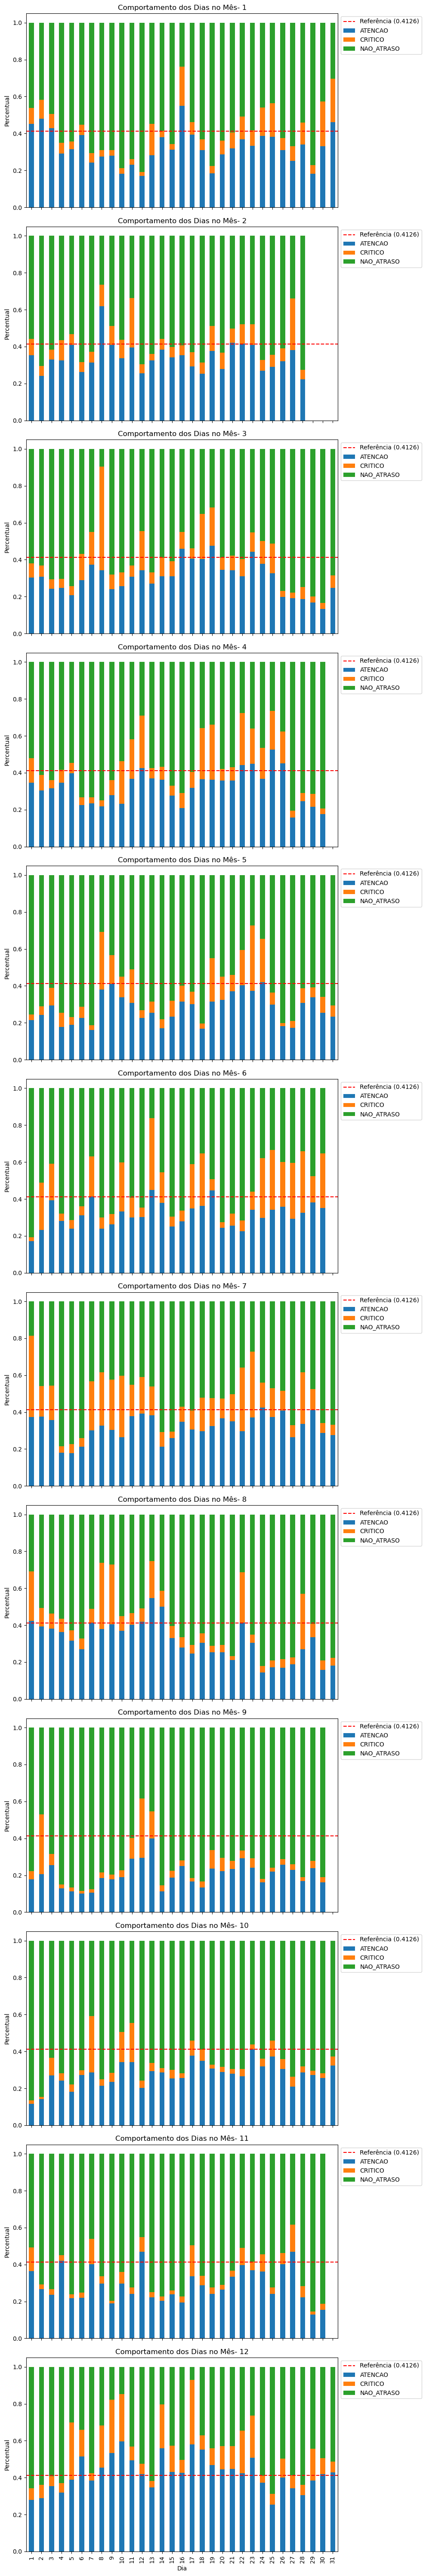

In [65]:
meses = base_mes_dia.index.get_level_values('month').unique()

# Criar uma figura e eixos para os gráficos
fig, axs = plt.subplots(nrows=len(meses), ncols=1, figsize=(10, len(meses) * 5), sharex=True)

if len(meses) == 1:
    axs = [axs]  # Garantir que axs seja uma lista se houver apenas um gráfico

# Plotar um gráfico para cada mês
for i, mes in enumerate(meses):
    dados_mes = base_mes_dia.loc[mes]
    dados_mes.plot(kind='bar', stacked=True, ax=axs[i], title=f'Comportamento dos Dias no Mês- {mes}')
    axs[i].set_xlabel('Dia')
    axs[i].set_ylabel('Percentual')
    axs[i].axhline(y=0.4126, color='red', linestyle='--', label=f'Referência ({0.4126})')
    axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Ajustar o layout
plt.tight_layout()
plt.show()

Levando em conta a classificação que fizemos dos meses de Férias, Baixa temporada e Padrão, podemos ter a seguinte conclusão:
- Meses de Férias: O período critico é de ultima semana de junho até dia 14 de agosto
- Meses de Baixa temporada e Padrão: Segue o comportamento observado no geral 

### Conclusões

- Podemos determinar os dias mais críticos em relação ao atraso, assim como definir o período do ano em que temos maior incidência de voos atrasados